In [103]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [104]:
#from IPython.display import HTML

#HTML("""
#<style>

#div.text_cell_render { /* Customize text cells */
#font-family: 'Comic Sans MS'}</style>""")

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

## <span style="color:steelblue"> Report of Activities in support of the IBA-IOBS Project: ''Proton Therapy vs. Traditional Radiation therapy: Total Cost of care, Effects on Survival, liklihood of complications and Quality of Life.''</span>

Below we will present

* a timeline of the steps taken to acquire the SEER-Medicare data
    * All necessary steps have been taken; SEER-Medicare mailed a package containing the data on 17 Aug 2016.
* a brief description of a commecial claims data source, including the results of pricing inquiries.
    * Truven Health, de-identified commercial (and Medicare) claims data
* a description of the SEER-Medicare data files and their format.
* updated estimates of the number of proton therapy patients in the data ($\approx$ 5000)

as well as work and results on Patient Matching using KDTrees; a more direct approach to patient matching than the traditional Propensity Score Matching methods. Needed as a foundational step to make meaningful comparisons between Proton Therapy patients and their traditional radiation thearpy counterparts.

* [prostate cancer patients example matches](http://nbviewer.jupyter.org/format/slides/github/doolingdavid/SEERMATCH2/blob/master/prostate_example.ipynb#/74)
* [H & N cancer patients matches](http://nbviewer.jupyter.org/format/slides/github/doolingdavid/SEERMATCH2/blob/master/all_other_example.ipynb?flush_cache=True#/62)

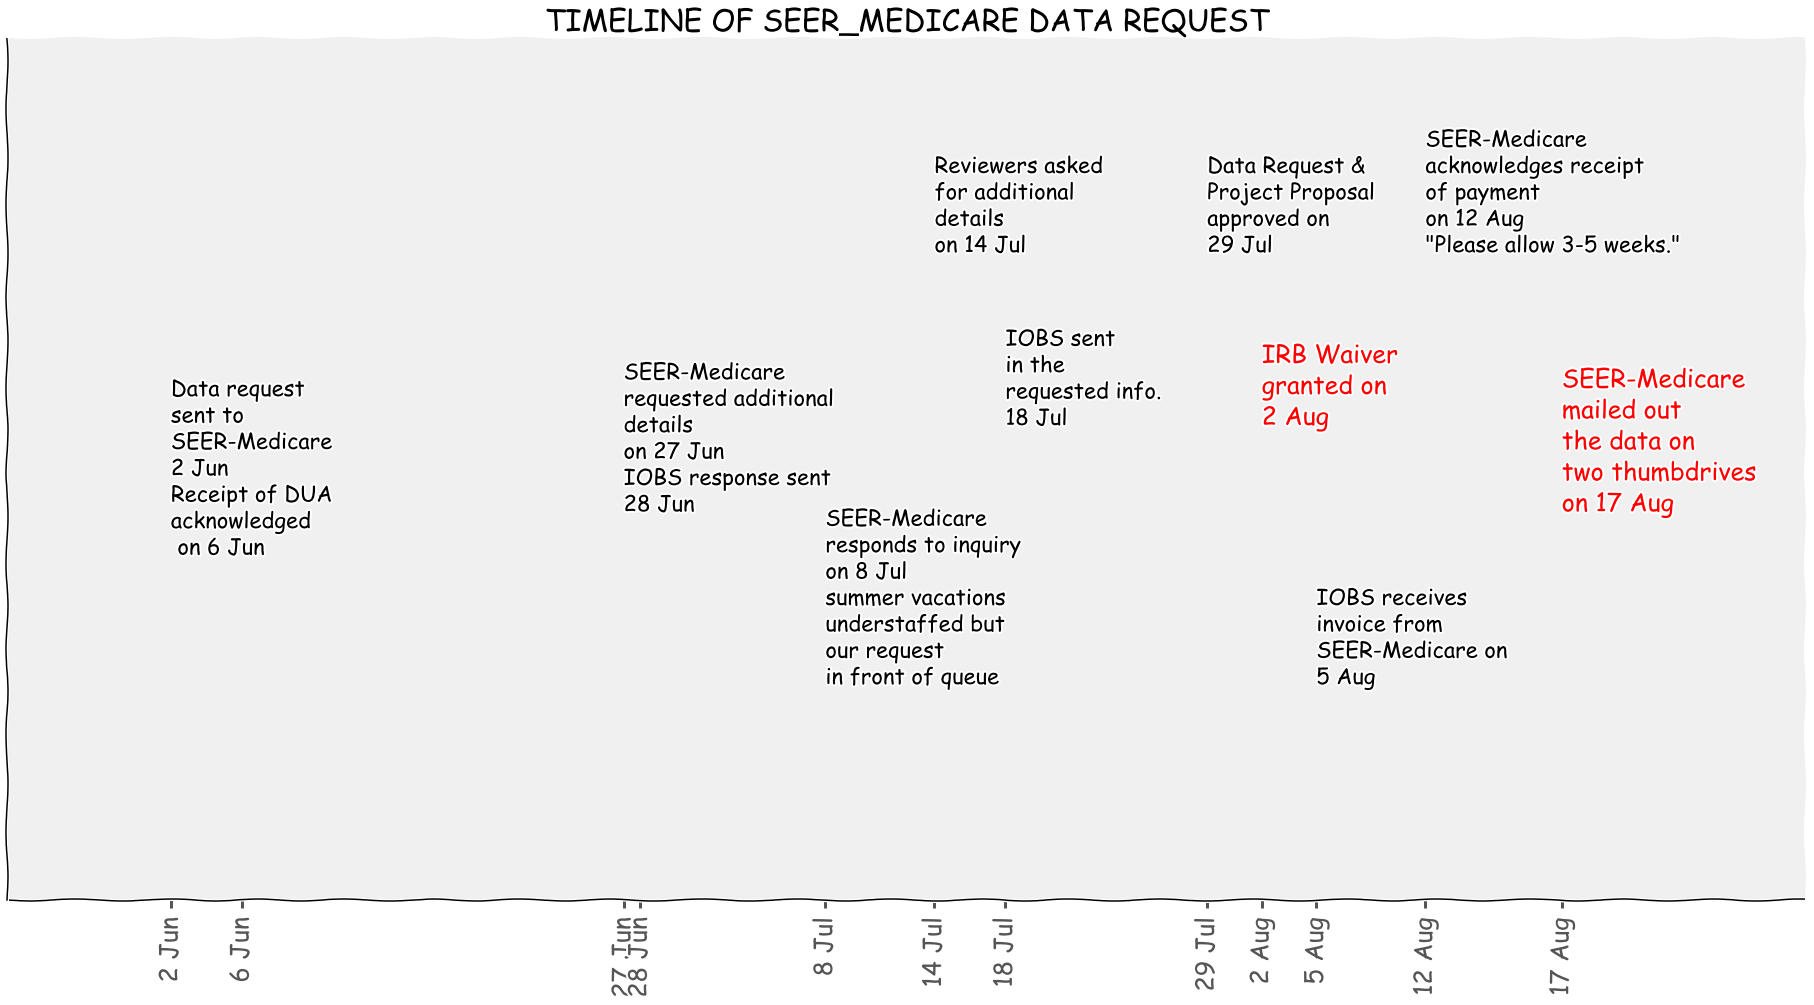

In [106]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Monroe
    # http://xkcd.com/418/
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes((0.0, 0.0, 2.5, 2))
    #ax.bar([-0.325, 1.0 - 0.325], [0, 100], 0.25)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([0, .13, .83, .86, 1.2,
                   1.4, 1.53, 1.9, 2.0,
                  2.1, 2.3, 2.55])
    ax.set_xlim([-0.3, 3])
    ax.set_ylim([0, 2])
    ax.set_xticklabels(['2 Jun', '6 Jun', '27 Jun', '28 Jun','8 Jul', 
                       '14 Jul', '18 Jul', '29 Jul', '2 Aug',
                       '5 Aug', '12 Aug', '17 Aug'],
                      rotation=90)
    
    ax.tick_params(axis='x',labelsize=25)
    plt.yticks([])

    ax.text(0,.8, 'Data request\nsent to\nSEER-Medicare\n2 Jun\nReceipt of DUA\n' +
    'acknowledged\n on 6 Jun', 
           style='italic',fontsize=22)
    
    
    ax.text(.83,.9, 'SEER-Medicare\nrequested additional\n' +
    'details\non 27 Jun\nIOBS response sent\n28 Jun', 
           style='italic',fontsize=22)
    
    ax.text(1.2, .5, 'SEER-Medicare\nresponds to inquiry\non 8 Jul\nsummer vacations\nunderstaffed but\n' + 
           'our request\nin front of queue',
           style='italic',fontsize=22)
    
    ax.text(1.4, 1.5,'Reviewers asked\nfor additional\ndetails\non 14 Jul',
           style='italic',fontsize=22)
    
    
    ax.text(1.53, 1.1, 'IOBS sent\nin the\nrequested info.\n18 Jul',
           style='italic',fontsize=22)
    
    ax.text(1.9,1.5,'Data Request &\nProject Proposal\napproved on\n' + 
           '29 Jul',style='italic',fontsize=22)
    
    
    ax.text(2.0, 1.1, 'IRB Waiver\ngranted on\n2 Aug',
           style='italic',fontsize=25,color='red')
    
    
    ax.text(2.1, .5, 'IOBS receives\ninvoice from\n' + 
           'SEER-Medicare on\n5 Aug',
           style='italic',fontsize=22)
    
    
    ax.text(2.3, 1.5, 'SEER-Medicare\nacknowledges receipt\nof payment\n' +
           'on 12 Aug\n"Please allow 3-5 weeks."',
           style='italic',fontsize=22)
    
    ax.text(2.55, .9, 'SEER-Medicare\nmailed out\nthe data on\ntwo thumbdrives\n' + 
           'on 17 Aug',
           style='italic',fontsize=25,color='red')
    
    
    plt.annotate(
        'THE DAY I REALIZED\nI COULD COOK BACON\nWHENEVER I WANTED',
        xy=(70, 1), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))
    
    plt.title("TIMELINE OF SEER_MEDICARE DATA REQUEST",fontsize=30)

#    fig.text(
    #    0.5, 0.05,
    #    '"The Data So Far" from xkcd by Randall Monroe',
     #   ha='center')

#fig.set_size_inches(5, 6)        
#fig.savefig('timeline.png',dpi=100)
plt.show()

### <font color='steelblue'>Will have SEER-Medicare Data on site very soon if not already here</font>

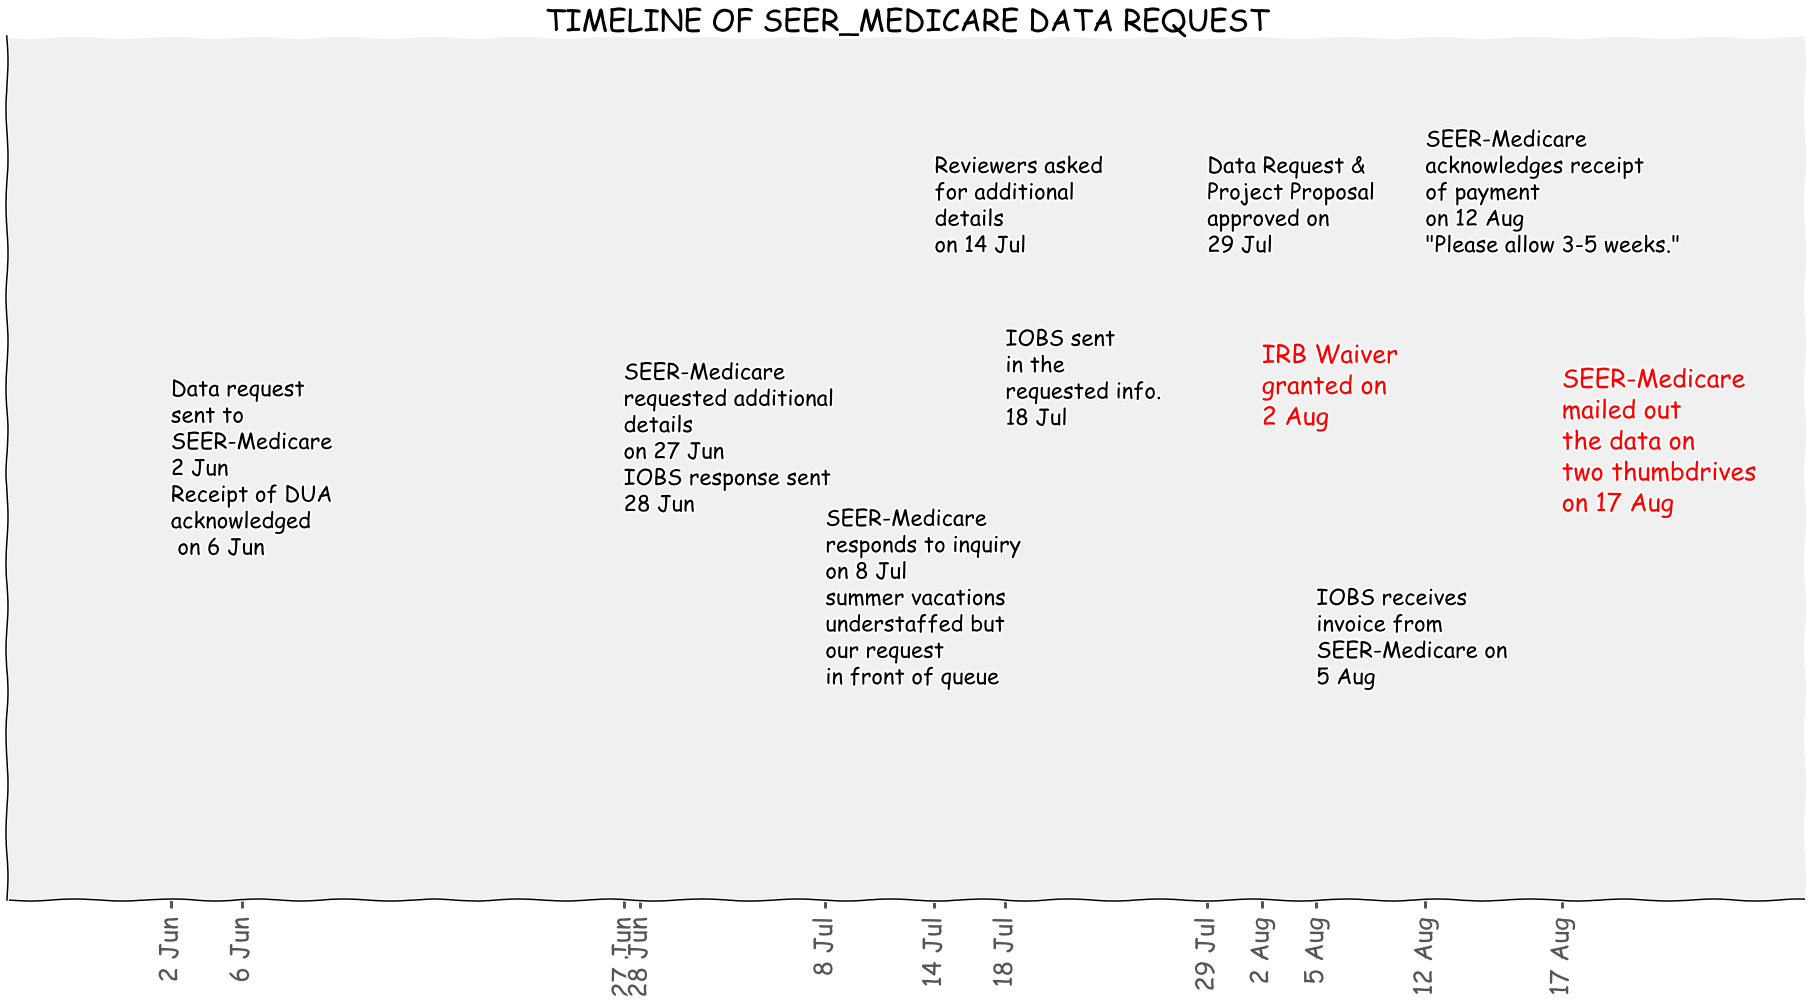

In [107]:
from IPython.display import Image
Image('timeline.png',embed=True)

In [108]:
from IPython.display import IFrame

#### Another data source: Truven Health MarketScan Databases

In [109]:
IFrame("http://truvenhealth.com/markets/life-sciences/products/data-tools/marketscan-databases",
      width=800,height=400)

## <font color='steelblue'>Description of the SEER-Medicare Data Files format</font>

* Patient Entitlement and Diagnosis Summary File (PEDSF)
* Medicare Provider Analysis and Review (MEDPAR)
* Carrier Claims (old file name Physician/Supplier Part B (NCH))
* Outpatient Claims
* Home Health Agency (HHA)
* Hospice
* Durable Medical Equipment (DME)
* Medicare Part D Data

#### PEDSF File Documentation

In [110]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/aboutdata/pedsf_attachment_a.pdf",
      width=800,height=400)

### <font color='steelblue'>The PEDSF File is almost identical to the SEER incidence files</font>

Below are the first 5 lines of the one of the breast cancer SEER data files.

In [111]:
N = 5
fin = 'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT'
from itertools import islice
with open(fin) as myfile:
    head = list(islice(myfile, N))
print(head)

['070000030000001502201 020601932   02111992C5052850038500391100810  00015                   4119                                                                      009020    01             213     260001745C505      1161023 099801311011010    009011    000000000010 369999   11158                   02381                  15000010         99     8    100000\n', '070000570000001502501 020761920   02061996C5091850038500321102010  09800                   4119                                                                      019310    01             216     260001749C509      1161023 0998013110110101   009003    370003700040 369999   11158                   01951                  18000010         99     8    100000\n', '070000660000001502501 020701924   02061994C5082850038500331101210  09800                   4889                                                                      009040    01             215     260001748C508      1161023 099801311011010    009003    500605006040 369

#### MEDPAR File Documentation

From the MEDPAR file, the columns (patient_id, MEDPAR Admission Date, MEDPAR Discharge Date, MEDPAR Total Charge) will be used to find the Total Charges for each claim as a function of Admission Date for each patient_id.

In [112]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/MEDPAR.pdf",
      width=800,height=400)

#### Carrier Claims File Documentation

Similarly, the columns (patient_id, CLAIM FROM DATE, CLAIM THROUGH DATE, LINE PAYMENT AMOUNT, CLAIM PAYMENT AMOUNT, NCH CLAIM PROVIDER PAYMENT AMOUNT, CARRIER CLAIM BENEFICIARY PAID AMOUNT) will be used.

In [113]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/NCH.pdf",
      width=800,height=400)

#### Outpatient Claims File Documentation

In the same manner, the columns (patient_id, CLAIM FROM DATE, CLAIM THROUGH DATE, CLAIM PAYMENT AMOUNT, CARRIER TOTAL CHARGE AMOUNT) will be used.

In [114]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/OUTPAT.pdf",
      width=800, height=400)

#### Home Health Agency File Documentation

Relevant columns for total cost of care calculations: (patient_id, CLAIM FROM DATE, CLAIM THROUGH DATE, CLAIM PAYMENT AMOUNT, CLAIM TOTAL CHARGE AMOUNT)

In [115]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/HHA.pdf",
      width=800,height=400)

#### Hospice File Documentation

Columns contributing to the total cost of care calulcation: (patient_id, CLAIM FROM DATE, CLAIM THROUGH DATE, CLAIM PAYMENT AMOUNT, CLAIM TOTAL CHARGE AMOUNT)

In [116]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/HOSP.pdf",
      width=800, height=400)

#### Durable Medical Equipment (DME) File Documentation

Columns contributing to the total cost of care calculations: (patient_id, CLAIM FROM DATE, CLAIM THROUGH DATE, Claim Payment Amount)

In [117]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/DME.pdf",
      width=800,height=400)

#### Prescription Drug Event File

Columns contributing to the total cost of care calculations: (patient_id, RX Service Date, Patient Pay Amount,
Gross Drug Cost)

In [118]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/medicare/partd.pdf",
      width=800,height=400)

## <font color='steelblue'>Identifying the Proton Therapy Patients</font>

The subset of the data that includes patients treated with proton therapy will be identified via the HCPCS/CPT codes:

* 77520 - Proton trmt simle w/o comp
* 77522 - Proton trmt simple w/comp
* 77523 - Proton trmt intermediate
* 77525 - Proton treatment complex

as well as the HCPCS code S8030 (Scleral application of tantalum ring(s) for localization of lesions for proton beam therapy). These ```patient_id``` values will be identified using the columns:

* outpatient claims file: ```HCPCS CODE, HCPCS INITIAL MODIFIER CODE, HCPCS SECOND MODIFIER CODE, HCPCS THIRD MODIFIER CODE```
* carrier claims file: ```LINE HCPCS CODE, LINE HCPCS INITIAL MODIFIER CODE, LINE HCPCS SECOND MODIFIER CODE, LINE HCPCS THIRD MODIFIER CODE, LINE HCPCS FOURTH MODIFIER CODE```

Since 1991, the Center for Medicare & Medicaid Services (CMS)External Web Site Policy has collected physician/supplier (Part B) bills for 100 percent of all claims. These bills, known as the National Claims History (NCH) records, are largely from physicians although the file also includes claims from other non-institutional providers such as physician assistants, clinical social workers, nurse practitioners, independent clinical laboratories, ambulance providers, and stand-alone ambulatory surgical centers. The claims are processed by carriers working under contract to CMS. Each carrier claim must include a Health Care Procedure Classification Code (HCPCS) to describe the nature of the billed service. The HCPCS is composed primarily of CPT-4 codes developed by the American Medical AssociationExternal Web Site Policy, with additional codes specific to CMS. Each HCPCS code on the carrier bill must be accompanied by an ICD-9 diagnosis code, providing a reason for the service. In addition each bill has the fields for the dates of service, reimbursement amount, encrypted provider numbers (e.g., UPIN), and beneficiary demographic data.


## <font color='steelblue'>SEER-Medicare now provides a file "to give investigators an estimate of specific medical services."</font>

In [119]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/aboutdata/hcpcs.html",
      width=800,height=400)

In [120]:
names = ['HCPCS',1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,
        2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013]

dfcodes = pd.read_csv('allsites.all.hcpcs.table.csv',skiprows=4,
                     names=names)



dfproton = dfcodes[dfcodes['HCPCS'].isin(['77520','77522','77523','77525','S8030'])].copy()
dfproton = dfproton.set_index('HCPCS')

In [121]:
dfproton.replace(['#'],[0],inplace=True)
#dfproton[2013] = dfproton[2013].astype('int')
#dfproton[2012] = dfproton[2012].astype('int')
for x in range(1991,2014):
    dfproton[x] = dfproton[x].astype('int')
dfproton[2013].sum()

191

## <font color='steelblue'>All Cancer Sites</font>

In [122]:
dfproton['tot'] = dfproton.sum(axis=1)
dfproton['tot']
print(dfproton['tot'].sum())
dfproton

4993


,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,tot
HCPCS,,,,,,,,,,,,,,,,,,,,,
77520,0,0,0,0,0,0,0,0,0,162,...,25,19,34,43,23,18,28,16,0,412
77522,0,0,0,0,0,0,0,0,0,0,...,260,214,248,253,234,254,311,160,58,3124
77523,0,0,0,0,0,0,0,0,0,19,...,51,72,80,101,111,127,140,130,121,1183
77525,0,0,0,0,0,0,0,0,0,0,...,18,14,18,26,14,26,36,11,12,274
S8030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <font color='steelblue'>Prostate Cancer</font>

In [123]:
names = ['HCPCS',1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,
        2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013]

dfprostatecodes = pd.read_csv('prostate.all.hcpcs.table.csv',skiprows=4,
                     names=names)

#dfprostatecodes.head()

dfprostatecodes = dfprostatecodes[dfprostatecodes['HCPCS'].isin(['77520','77522','77523','77525','S8030'])].copy()
dfprostatecodes = dfprostatecodes.set_index('HCPCS')
dfprostatecodes

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
HCPCS,,,,,,,,,,,,,,,,,,,,,
77520,#,#,#,#,#,#,#,#,#,110,...,#,#,#,#,#,#,#,#,#,#
77522,#,#,#,#,#,#,#,#,#,#,...,226,208,176,206,208,205,222,261,127,26
77523,#,#,#,#,#,#,#,#,#,#,...,#,#,12,21,37,50,56,61,41,21
77525,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,12,#,#


In [124]:
dfprostatecodes.replace(['#'],[0],inplace=True)
#dfproton[2013] = dfproton[2013].astype('int')
#dfproton[2012] = dfproton[2012].astype('int')
for x in range(1991,2014):
    dfprostatecodes[x] = dfprostatecodes[x].astype('int')
dfprostatecodes[2013].sum()

47

In [125]:
dfprostatecodes['tot'] = dfprostatecodes.sum(axis=1)
dfprostatecodes['tot']
print(dfprostatecodes['tot'].sum())

3000


## So we estimate that there are approximately 1670 Head and Neck Cancer Cases that have received Proton Therapy in the SEER-Medicare Data

## <font color='steelblue'>Lung Cancer</font>

In [126]:
names = ['HCPCS',1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,
        2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013]

dflungcodes = pd.read_csv('lung.all.hcpcs.table.csv',skiprows=4,
                     names=names)

#dfprostatecodes.head()

dflungcodes = dflungcodes[dflungcodes['HCPCS'].isin(['77520','77522','77523','77525','S8030'])].copy()
dflungcodes = dflungcodes.set_index('HCPCS')
dflungcodes

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
HCPCS,,,,,,,,,,,,,,,,,,,,,
77520,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,#,#,#
77522,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,#,#,#
77523,#,#,#,#,#,#,#,#,#,#,...,#,#,14,17,15,23,20,15,17,14
77525,#,#,#,#,#,#,#,#,#,#,...,#,#,#,#,#,#,#,#,#,#


In [127]:
dflungcodes.replace(['#'],[0],inplace=True)
#dfproton[2013] = dfproton[2013].astype('int')
#dfproton[2012] = dfproton[2012].astype('int')
for x in range(1991,2014):
    dflungcodes[x] = dflungcodes[x].astype('int')
dflungcodes[2013].sum()

14

In [128]:
dflungcodes['tot'] = dflungcodes.sum(axis=1)
dflungcodes['tot']
print(dflungcodes['tot'].sum())

158


## Example illustrating the need for patient matching in observational studies

Imagine a rental car agency that suspects that gasoline B gets better miles per gallon than does gasoline A. The effect is **real**, in the sense that if they use gasoline A for all cars one month at one location, and also use gasoline B at the sister location, gasoline A perfroms better.

But if you apply an unpaired t-test to see if this effect may be due to chance, you cannot rule out that is in fact due to chance:

In [129]:
import pandas as pd
gas_a_list =[27.01, 20, 23.41, 25.22, 30.11,
             25.55, 22.23, 19.78, 33.45, 25.22]

gas_b_list = [26.95, 20.44, 25.05, 26.32, 29.56,
             26.60, 22.93, 20.23, 33.95, 26.01]

dfgas = pd.DataFrame({'gasa': gas_a_list,
                         'gasb': gas_b_list})
dfgas

,gasa,gasb
0,27.01,26.95
1,20.00,20.44
2,23.41,25.05
3,25.22,26.32
4,30.11,29.56
5,25.55,26.60
6,22.23,22.93
7,19.78,20.23
8,33.45,33.95
9,25.22,26.01


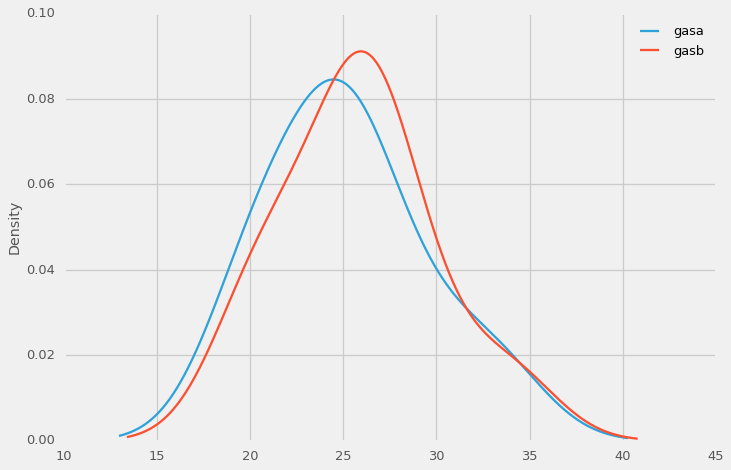

In [130]:
dfgas.plot.kde();

If you perform a standard, non-paired hypothesis test just to see if the means differ, you conclude that its just random luck and that there is no effect:

Calculate the T-test for the means of TWO INDEPENDENT samples of scores.

In [131]:
from scipy.stats import ttest_ind

t, p = ttest_ind(dfgas.gasa.as_matrix(),
               dfgas.gasb.as_matrix())

print(t,p)

-0.323714027978 0.749885487308


The problem is that even though gas b is slightly better than gas a, the large standard deviations induce a large standard error - the mileages varied widely from one car to the next. Analaglous to our situation with the SEER data.

If you assign gas a and gas b to the **same** car on different days, and then record the mileage, you can rule out the null hypothesis even with this small dataset. This happens because the standard deviations of the differences among the pairs are now small. This difference column, by comparing gas performance within a single car, eliminates the variabilty between cars.

In [132]:
dfgas['diff'] = dfgas.gasa - dfgas.gasb
dfgas.describe()

,gasa,gasb,diff
count,10.000000,10.000000,10.000000
mean,25.198000,25.804000,-0.606000
std,4.268897,4.101366,0.614278
min,19.780000,20.230000,-1.640000
25%,22.525000,23.460000,-0.985000
50%,25.220000,26.165000,-0.600000
75%,26.645000,26.862500,-0.442500
max,33.450000,33.950000,0.550000


In [133]:
from scipy.stats import ranksums, ttest_rel

ttest_rel(dfgas.gasa.as_matrix(),
               dfgas.gasb.as_matrix())

Ttest_relResult(statistic=-3.1196615512720802, pvalue=0.012325349247526556)

A non-parametric version of the paired t-test confirms the result that gas b outperforms gas a:

In [134]:
from scipy.stats import ranksums, wilcoxon

t, p = wilcoxon(dfgas.gasa.as_matrix(),
               dfgas.gasb.as_matrix())

print(t,p)

6.0 0.0284168641749


So patient-matching allows for increased sensitivity to effects by substantially decreasing the standard deviations used to probe for the effect (the difference column, which eliminates the noise associated with the variability between patients). 


[Here is an illustration the of the Patient Matching methodology applied to Prostate cancer patients](http://nbviewer.jupyter.org/format/slides/github/doolingdavid/SEERMATCH2/blob/master/prostate_example.ipynb#/)

and

[Here is an illustation of the Patient Mataching methodology applied to H & N cancer patients](http://nbviewer.jupyter.org/format/slides/github/doolingdavid/SEERMATCH2/blob/master/all_other_example.ipynb?flush_cache=True#/)

In [135]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_nb.css", "r").read()
    return HTML(styles)
css_styling()